# PART 2: Swaption Calibration

### Import packages

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import brentq
from scipy.optimize import least_squares
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 8

 # <a id = "top">Contents</a>

# [1. Data Import](#p1)
# [2. Displaced-Diffusion Model](#p2)
# [3. SABR Model](#p3)
# [4. Price Swaptions with Different Models](#p4)

#  <a id = "p1"> 1.<font color = "green">Data Import [(back to contents)](#top)

In [3]:
swap_data = pd.read_excel("IR Data.xlsx",sheet_name="Swaption")
swap_data.columns = swap_data.iloc[1]
swap_data = swap_data.drop([0,1],axis=0).reset_index(drop = True)
swap_data.head()

1 Expiry Tenor -200bps -150bps -100bps  -50bps  -25bps    ATM +25bps +50bps  \
0     1Y    1Y   91.57   62.03   44.13  31.224  26.182   22.5  20.96   21.4   
1     1Y    2Y   83.27   61.24   46.57  35.807  31.712  28.72  27.12  26.84   
2     1Y    3Y   73.92   56.87   44.77  35.745  32.317  29.78  28.29   27.8   
3     1Y    5Y   55.19   44.64   36.51  30.242  27.851  26.07  24.98  24.56   
4     1Y   10Y   41.18   35.04  30.207  26.619  25.351  24.47  23.98  23.82   

1 +100bps +150bps +200bps  
0   24.34  27.488  30.297  
1   28.51  31.025  33.523  
2   28.77  30.725  32.833  
3   25.12  26.536  28.165  
4   24.25  25.204  26.355

In [4]:
forward_rate = pd.read_excel("Forward Swap Rate.xlsx")
forward_rate.head()

Unnamed: 0 Start Tenor  Forward Swap Rate
0           0    1Y    1Y           0.032007
1           1    1Y    2Y           0.033259
2           2    1Y    3Y           0.034011
3           3    1Y    5Y           0.035255
4           4    1Y   10Y           0.038428

In [5]:
df_strike = pd.DataFrame()
bps = np.array([-200, -150, -100, -50, -25, 0, 25, 50, 100, 150, 200])/1e4
for i in list(forward_rate["Forward Swap Rate"]):
    df_strike = pd.concat([df_strike, pd.DataFrame(i+bps)], axis = 1)
df_strike.index = swap_data.columns[2:13]
df_strike.columns = [(x,y) for x, y in zip(swap_data["Expiry"], swap_data["Tenor"])]

In [6]:
df_strike

(1Y, 1Y)  (1Y, 2Y)  (1Y, 3Y)  (1Y, 5Y)  (1Y, 10Y)  (5Y, 1Y)  \
1                                                                      
-200bps  0.012007  0.013259  0.014011  0.015255   0.018428  0.019274   
-150bps  0.017007  0.018259  0.019011  0.020255   0.023428  0.024274   
-100bps  0.022007  0.023259  0.024011  0.025255   0.028428  0.029274   
-50bps   0.027007  0.028259  0.029011  0.030255   0.033428  0.034274   
-25bps   0.029507  0.030759  0.031511  0.032755   0.035928  0.036774   
ATM      0.032007  0.033259  0.034011  0.035255   0.038428  0.039274   
+25bps   0.034507  0.035759  0.036511  0.037755   0.040928  0.041774   
+50bps   0.037007  0.038259  0.039011  0.040255   0.043428  0.044274   
+100bps  0.042007  0.043259  0.044011  0.045255   0.048428  0.049274   
+150bps  0.047007  0.048259  0.049011  0.050255   0.053428  0.054274   
+200bps  0.052007  0.053259  0.054011  0.055255   0.058428  0.059274   

         (5Y, 2Y)  (5Y, 3Y)  (5Y, 5Y)  (5Y, 10Y)  (10Y, 1Y)  (10Y, 2Y)  \
1                                                                        
-200bps  0.020075  0.020072  0.021093   0.023634   0.022189   0.023116   
-150bps  0.025075  0.025072  0.026093   0.028634   0.027189   0.028116   
-100bps  0.030075  0.030072  0.031093   0.033634   0.032189   0.033116   
-50bps   0.035075  0.035072  0.036093   0.038634   0.037189   0.038116   
-25bps   0.037575  0.037572  0.038593   0.041134   0.039689   0.040616   
ATM      0.040075  0.040072  0.041093   0.043634   0.042189   0.043116   
+25bps   0.042575  0.042572  0.043593   0.046134   0.044689   0.045616   
+50bps   0.045075  0.045072  0.046093   0.048634   0.047189   0.048116   
+100bps  0.050075  0.050072  0.051093   0.053634   0.052189   0.053116   
+150bps  0.055075  0.055072  0.056093   0.058634   0.057189   0.058116   
+200bps  0.060075  0.060072  0.061093   0.063634   0.062189   0.063116   

         (10Y, 3Y)  (10Y, 5Y)  (10Y, 10Y)  
1                                          
-200bps   0.024097   0.026249    0.033458  
-150bps   0.029097   0.031249    0.038458  
-100bps   0.034097   0.036249    0.043458  
-50bps    0.039097   0.041249    0.048458  
-25bps    0.041597   0.043749    0.050958  
ATM       0.044097   0.046249    0.053458  
+25bps    0.046597   0.048749    0.055958  
+50bps    0.049097   0.051249    0.058458  
+100bps   0.054097   0.056249    0.063458  
+150bps   0.059097   0.061249    0.068458  
+200bps   0.064097   0.066249    0.073458

In [7]:
discount = pd.read_excel("IRS_data_final.xlsx")
discount

Unnamed: 0  Tenor      Rate     ON_DF  LIBOR_DF  LIBOR_Rate
0            0    0.5  0.025000  0.998752  0.987654    0.025000
1            1    1.0  0.028000  0.997009  0.972577    0.031005
2            2    1.5  0.029000  0.995270  0.957378    0.031751
3            3    2.0  0.030000  0.993531  0.942179    0.032263
4            4    2.5  0.030750  0.991773  0.926330    0.034218
5            5    3.0  0.031500  0.990015  0.910482    0.034814
6            6    3.5  0.032000  0.988066  0.894731    0.035207
7            7    4.0  0.032500  0.986117  0.878981    0.035838
8            8    4.5  0.032750  0.984150  0.863985    0.034713
9            9    5.0  0.033000  0.982184  0.848989    0.035326
10          10    5.5  0.033500  0.979740  0.832796    0.038889
11          11    6.0  0.034000  0.977295  0.816603    0.039660
12          12    6.5  0.034500  0.974850  0.800409    0.040462
13          13    7.0  0.035000  0.972406  0.784216    0.041298
14          14    7.5  0.035333  0.969668  0.768965    0.039666
15          15    8.0  0.035667  0.966929  0.753714    0.040469
16          16    8.5  0.036000  0.964191  0.738463    0.041305
17          17    9.0  0.036333  0.961453  0.723212    0.042176
18          18    9.5  0.036667  0.958715  0.707961    0.043084
19          19   10.0  0.037000  0.955977  0.692710    0.044033
20          20   10.5  0.037300  0.953140  0.678547    0.041745
21          21   11.0  0.037600  0.950304  0.664384    0.042635
22          22   11.5  0.037900  0.947467  0.650221    0.043564
23          23   12.0  0.038200  0.944631  0.636058    0.044534
24          24   12.5  0.038500  0.941794  0.621896    0.045548
25          25   13.0  0.038800  0.938958  0.607733    0.046609
26          26   13.5  0.039100  0.936121  0.593570    0.047721
27          27   14.0  0.039400  0.933285  0.579407    0.048888
28          28   14.5  0.039700  0.930448  0.565244    0.050113
29          29   15.0  0.040000  0.927611  0.551081    0.051401
30          30   15.5  0.040500  0.924858  0.536794    0.053228
31          31   16.0  0.041000  0.922104  0.522508    0.054684
32          32   16.5  0.041500  0.919351  0.508222    0.056221
33          33   17.0  0.042000  0.916597  0.493935    0.057847
34          34   17.5  0.042500  0.913844  0.479649    0.059570
35          35   18.0  0.043000  0.911090  0.465363    0.061399
36          36   18.5  0.043500  0.908337  0.451077    0.063343
37          37   19.0  0.044000  0.905583  0.436790    0.065415
38          38   19.5  0.044500  0.902829  0.422504    0.067627
39          39   20.0  0.045000  0.900076  0.408218    0.069994
40          40   20.5  0.045250  0.897442  0.398990    0.046256
41          41   21.0  0.045500  0.894809  0.389762    0.047351
42          42   21.5  0.045750  0.892176  0.380534    0.048499
43          43   22.0  0.046000  0.889542  0.371307    0.049704
44          44   22.5  0.046250  0.886909  0.362079    0.050971
45          45   23.0  0.046500  0.884275  0.352851    0.052304
46          46   23.5  0.046750  0.881642  0.343623    0.053709
47          47   24.0  0.047000  0.879008  0.334396    0.055191
48          48   24.5  0.047250  0.876375  0.325168    0.056757
49          49   25.0  0.047500  0.873741  0.315940    0.058415
50          50   25.5  0.047750  0.871108  0.306712    0.060172
51          51   26.0  0.048000  0.868474  0.297484    0.062039
52          52   26.5  0.048250  0.865841  0.288257    0.064025
53          53   27.0  0.048500  0.863207  0.279029    0.066142
54          54   27.5  0.048750  0.860574  0.269801    0.068404
55          55   28.0  0.049000  0.857941  0.260573    0.070827
56          56   28.5  0.049250  0.855307  0.251346    0.073427
57          57   29.0  0.049500  0.852674  0.242118    0.076225
58          58   29.5  0.049750  0.850040  0.232890    0.079246
59          59   30.0  0.050000  0.847407  0.223662    0.082515

#  <a id = "p2"> 2.<font color = "green">Displaced-Diffusion Model [(back to contents)](#top)

$\sigma $ for displaced diffusion model is the at-the-money volatility

In [8]:
pd.concat([swap_data[["Expiry", "Tenor"]],swap_data["ATM"]/100],axis=1)

Expiry Tenor     ATM
0      1Y    1Y   0.225
1      1Y    2Y  0.2872
2      1Y    3Y  0.2978
3      1Y    5Y  0.2607
4      1Y   10Y  0.2447
5      5Y    1Y  0.2726
6      5Y    2Y  0.2983
7      5Y    3Y  0.2998
8      5Y    5Y   0.266
9      5Y   10Y  0.2451
10    10Y    1Y  0.2854
11    10Y    2Y  0.2928
12    10Y    3Y   0.294
13    10Y    5Y  0.2674
14    10Y   10Y  0.2437

Similar with option, we can value swaption in way below:
* For receiver swaption (similar with put option):
$$
V^{rec}_{n,\  N}\left( 0\right)  =P_{n+1,N}\left( 0\right)  \left[ K\Phi \left( -d_{2}\right)  -S_{n,N}\left( 0\right)\Phi \left( -d_{1}\right)  \right]  
$$
* For payer swaption (similar with call option):
$$
V^{payer}_{n,\  N}\left( 0\right)  =P_{n+1,N}\left( 0\right)  \left[ S_{n,N}\left( 0\right)  \Phi \left( d_{1}\right)  -K\Phi \left( d_{2}\right)  \right]  
$$

Furthermore, if the implied volatility skew we observed in the market is between normal and log normal, then we can write the pricing formula of payer swaption under displaced-diffusion model as:
$$
V^{payer}_{n,\  N}\left( 0\right)  =P_{n+1,N}\left( 0\right)  Black76Call\left( \frac{S_{n,N}\left( 0\right)  }{\beta } ,\  K+\frac{1-\beta }{\beta } S_{n,N}\left( 0\right)  ,\  \sigma \beta ,\  T\right)  
$$

In [9]:
#calculate PVBP
def calc_pvbp(t_begin, t_end):
    index_start = discount[discount["Tenor"] == t_begin+0.5].index[0]
    index_end = discount[discount["Tenor"] == t_end].index[0]
    discount_window = discount.loc[index_start:index_end, "ON_DF"]
    return(sum(0.5*discount_window))

#Black 76 pricing formula
def black76_payer(F, K, t, T, sigma):
    pvbp = calc_pvbp(t, t+T)
    d1 = (np.log(F/K)+(1/2)*(sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    price = pvbp * ((F*norm.cdf(d1)) - (K*norm.cdf(d2)))
    return price
def black76_receiver(F, K, t, T, sigma):
    pvbp = calc_pvbp(t, t+T)
    d1 = (np.log(F/K)+1/2*(sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    price = pvbp * ((K*norm.cdf(-d2)) - (F*norm.cdf(-d1)))
    return price

#Function of calculating implied volatility
def impliedVolatility_bs(S, K, price, t, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                black76_payer(S, K, t, T, x),
                                1e-12, 1000.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                black76_receiver(S, K, t, T, x),
                                1e-12, 1000.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan
    return impliedVol

#Displaced-Diffusion pricing formula
def dd_calc_price(T, t, F, K, beta, sigma, payoff):
    if (payoff.lower() == 'call'):
        return(black76_payer(F/beta, K+((1-beta)/beta)*F, t, T, sigma*beta))
    elif (payoff.lower() == 'put'):
        return(black76_receiver(F/beta, K+((1-beta)/beta)*F, t, T, sigma*beta))

#Displaced-Diffusion calibration
def ddcalibration(x, strikes, vols, S, t, T, sigma, payoff):
    err = 0.0
    for j, vol in enumerate(vols):
        price = dd_calc_price(T, t, S, strikes[j], x[0], sigma, payoff[j])
        err += (vol - impliedVolatility_bs(S, strikes[j], price, t, T, payoff[j]))**2
        #print(j)
    return err

Use `Least Squares` method to find the best fitted $\beta$

In [10]:
def DD_fit_beta(strike, implied_vol, S, t, T, sigma, payoff):
    initialGuess = [0.7]
    bounds = (0,1)
    res = least_squares(lambda x: ddcalibration(x,
                                              strike,
                                              implied_vol,
                                              S, t,
                                              T, sigma, payoff),
                    initialGuess, bounds = bounds)
    return res.x[0]

In [11]:
swap_data1 = swap_data.copy()
swap_data1["Tenor"] = [1,2,3,5,10,1,2,3,5,10,1,2,3,5,10]
swap_data1["Expiry"] = [1,1,1,1,1,5,5,5,5,5,10,10,10,10,10]
swap_data1

1   Expiry  Tenor -200bps -150bps -100bps  -50bps  -25bps    ATM +25bps  \
0        1      1   91.57   62.03   44.13  31.224  26.182   22.5  20.96   
1        1      2   83.27   61.24   46.57  35.807  31.712  28.72  27.12   
2        1      3   73.92   56.87   44.77  35.745  32.317  29.78  28.29   
3        1      5   55.19   44.64   36.51  30.242  27.851  26.07  24.98   
4        1     10   41.18   35.04  30.207  26.619  25.351  24.47  23.98   
5        5      1    67.8   49.09    38.4  31.485   29.06  27.26  26.04   
6        5      2   57.88   46.41  39.033  33.653  31.531  29.83  28.56   
7        5      3   53.43   44.44   38.18  33.437  31.536  29.98  28.76   
8        5      5   41.99  36.524  32.326  29.005  27.677   26.6  25.73   
9        5     10  34.417  30.948  28.148  25.954  25.136  24.51  23.99   
10      10      1   55.16   44.32  37.368  32.259   30.21  28.54  27.31   
11      10      2   51.17    42.9  37.078  32.622    30.8  29.28  28.09   
12      10      3   48.22   41.43    36.4  32.439  30.796   29.4  28.27   
13      10      5   40.55  35.891  32.181  29.144  27.857  26.74   25.8   
14      10     10  33.601  30.509  27.978  25.926  25.086  24.37  23.76   

1  +50bps +100bps +150bps +200bps  
0    21.4   24.34  27.488  30.297  
1   26.84   28.51  31.025  33.523  
2    27.8   28.77  30.725  32.833  
3   24.56   25.12  26.536  28.165  
4   23.82   24.25  25.204  26.355  
5   25.32   24.94   25.32   25.98  
6   27.65   26.71   26.54   26.76  
7   27.82   26.67    26.2   26.15  
8   25.02   24.06   23.57    23.4  
9   23.56   22.91   22.49   22.25  
10  26.45   25.61   25.52   25.78  
11   27.2   26.12   25.72   25.71  
12  27.38   26.18   25.58   25.37  
13  25.02   23.87   23.17    22.8  
14  23.24   22.44    21.9   21.56

In [12]:
beta_ls = []
for i in range(len(swap_data)):
    ivol = swap_data1.iloc[i,2:]/100
    strike = df_strike.iloc[:,i]
    par_rate = forward_rate["Forward Swap Rate"][i]
    df = pd.DataFrame({"ivol": ivol, "K": strike})
    df["payoff"] = df["K"].apply(lambda x: 'call' if x > par_rate else 'put')
    beta = DD_fit_beta(df["K"], df["ivol"], par_rate, swap_data1["Expiry"][i], swap_data1["Tenor"][i], swap_data1["ATM"][i]/100, df["payoff"])
    beta_ls.append(beta)
pd.DataFrame({"Expiry": swap_data1["Expiry"], "Tenor": swap_data1["Tenor"], "Beta": beta_ls})

Expiry  Tenor          Beta
0        1      1  1.635079e-10
1        1      2  6.209890e-08
2        1      3  9.101406e-13
3        1      5  3.132764e-06
4        1     10  2.489156e-05
5        5      1  8.973071e-07
6        5      2  1.571027e-07
7        5      3  1.579090e-05
8        5      5  7.319276e-06
9        5     10  5.778981e-02
10      10      1  5.174896e-07
11      10      2  4.086106e-08
12      10      3  1.620367e-06
13      10      5  6.130551e-05
14      10     10  6.459033e-04

Use best $\beta $ to calculate the implied volatility in displaced-diffusion model.

In [13]:
def calc_dd_vol(df,T,t,S,beta,sigma):
    df["price_dd"] = df.apply(lambda x: dd_calc_price (T, 
                                                             t, 
                                                             S, 
                                                             x["K"], 
                                                             beta, 
                                                             sigma, 
                                                             x["payoff"]),axis=1)
    df['vols_dd'] = df.apply(lambda x: impliedVolatility_bs(S,
                                                  x["K"],
                                                  x['price_dd'],
                                                  t, T,
                                                  x["payoff"]),axis=1)
    return df

In [14]:
def dd_calc_vol(i):
    ivol = swap_data1.iloc[i,2:]/100
    strike = df_strike.iloc[:,i]
    par_rate = forward_rate["Forward Swap Rate"][i]
    df = pd.DataFrame({"ivol": ivol, "K": strike})
    df["payoff"] = df["K"].apply(lambda x: 'call' if x > par_rate else 'put')
    beta = beta_ls[i]
    calc_dd_vol(df, swap_data1["Tenor"][i], swap_data1["Expiry"][i], par_rate, beta, swap_data1["ATM"][i]/100)
    
    return df["vols_dd"]

#  <a id = "p3"> 3.<font color = "green">SABR Model [(back to contents)](#top)

Apart from Displaced-Diffusion model, we can also use SABR model to calibrate the implied volatility of swaptions.

In [15]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if np.isclose(F, K).all():
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [16]:
def sabrcalibration(x, row, beta):    #x is a df there
    err = 0.0
    bp_changes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] 
    vols = row.iloc[3:14]
    F = row.iloc[2]
    T = row.iloc[0]
    
    for i, vol in enumerate(vols):
        K = F + bp_changes[i]
        err += (vol - SABR(F, K, T, x[0], beta, x[1], x[2]))**2
    return err

In [70]:
def sabr_vol(row):
    beta = 0.9 
    #sarb to fit market vol
    #different initial guess values will lead to different calibration results (very small difference)
    #bounds of three parameters also cause uncertainty of our results
    #thus we take the average of multiple results and perform multiple iterations
    #and finally find the guess value below can generate a relatively good calibration
    initialGuess = [0.2, -0.5, 1.05]
    #initialGuess = [0.190534, -0.519452, 1.049854]
    #initialGuess = [0.2, 0.2, 0.1]
    res = least_squares(lambda x: sabrcalibration(x, row, beta), initialGuess, max_nfev= 2000)
    alpha1 = res.x[0]
    rho1 = res.x[1]
    nu1 = res.x[2]

    return [alpha1, rho1, nu1]

In [71]:
fsr = pd.DataFrame({"start": swap_data1["Expiry"], 
                    "tenor": swap_data1["Tenor"], 
                    "fsr": forward_rate["Forward Swap Rate"]})
fsr[swap_data.columns[2:]] = swap_data[swap_data.columns[2:]]/100
fsr.head()

start  tenor       fsr -200bps -150bps  -100bps   -50bps   -25bps     ATM  \
0      1      1  0.032007  0.9157  0.6203   0.4413  0.31224  0.26182   0.225   
1      1      2  0.033259  0.8327  0.6124   0.4657  0.35807  0.31712  0.2872   
2      1      3  0.034011  0.7392  0.5687   0.4477  0.35745  0.32317  0.2978   
3      1      5  0.035255  0.5519  0.4464   0.3651  0.30242  0.27851  0.2607   
4      1     10  0.038428  0.4118  0.3504  0.30207  0.26619  0.25351  0.2447   

   +25bps  +50bps +100bps  +150bps  +200bps  
0  0.2096   0.214  0.2434  0.27488  0.30297  
1  0.2712  0.2684  0.2851  0.31025  0.33523  
2  0.2829   0.278  0.2877  0.30725  0.32833  
3  0.2498  0.2456  0.2512  0.26536  0.28165  
4  0.2398  0.2382  0.2425  0.25204  0.26355

In [72]:
lst = [sabr_vol(fsr.iloc[i]) for i in range(len(fsr))]

In [73]:
fsr['alpha'] = np.array(lst)[:,0]
fsr['rho'] = np.array(lst)[:,1]
fsr['nu'] = np.array(lst)[:,2]
pd.concat([fsr.loc[:,"start":"tenor"], fsr.loc[:,"alpha":"nu"]],axis = 1)

start  tenor     alpha       rho        nu
0       1      1  0.139074 -0.633223  2.049416
1       1      2  0.184650 -0.525114  1.677383
2       1      3  0.196851 -0.482848  1.438125
3       1      5  0.178059 -0.414493  1.064842
4       1     10  0.169984 -0.255690  0.792209
5       5      1  0.166618 -0.585668  1.340427
6       5      2  0.199534 -0.547030  1.062005
7       5      3  0.210314 -0.549687  0.936773
8       5      5  0.190244 -0.506814  0.674546
9       5     10  0.174809 -0.415705  0.511310
10     10      1  0.178282 -0.548440  1.010303
11     10      2  0.196313 -0.547530  0.928630
12     10      3  0.208253 -0.553589  0.871684
13     10      5  0.201583 -0.563656  0.722512
14     10     10  0.180231 -0.508403  0.580357

Use the best $\alpha $, $\rho $, $\nu $ to calculate implied volatility of swaption.

In [74]:
def cal_sabr_vols(row):    #x is a df there
    beta = 0.9
    bp_changes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] 
    alpha = row.iloc[-3]
    rho = row.iloc[-2]
    nu = row.iloc[-1]
    F = row.iloc[2]
    T = row.iloc[0]
    vols = []
    
    for i in range(len(bp_changes)):
        K = F + bp_changes[i]
        # print(F,K,T,beta, vol)
        # return
        vols.append(SABR(F, K, T, alpha, beta, rho, nu))
    return vols

### Calibration graph (Displaced-Diffusion+SABR)

In [75]:
def draw_graph(x):
    plt.scatter(df_strike.iloc[:,x], swap_data.iloc[x,2:]/100, label='Market Imp. Vol.',color = "#F46E49")
    plt.plot(df_strike.iloc[:,x], dd_calc_vol(x), label='DD Calibration',color = "#7DABCF")
    plt.plot(df_strike.iloc[:,x], cal_sabr_vols(fsr.iloc[i]), label = 'SABR Calibration', color = "#FFCB5D")
    plt.legend()
    plt.title("Swaption("+swap_data["Expiry"][x]+" x "+swap_data["Tenor"][x]+")")
    plt.ylabel("Implied Volatility")
    plt.xlabel("Strike Price")

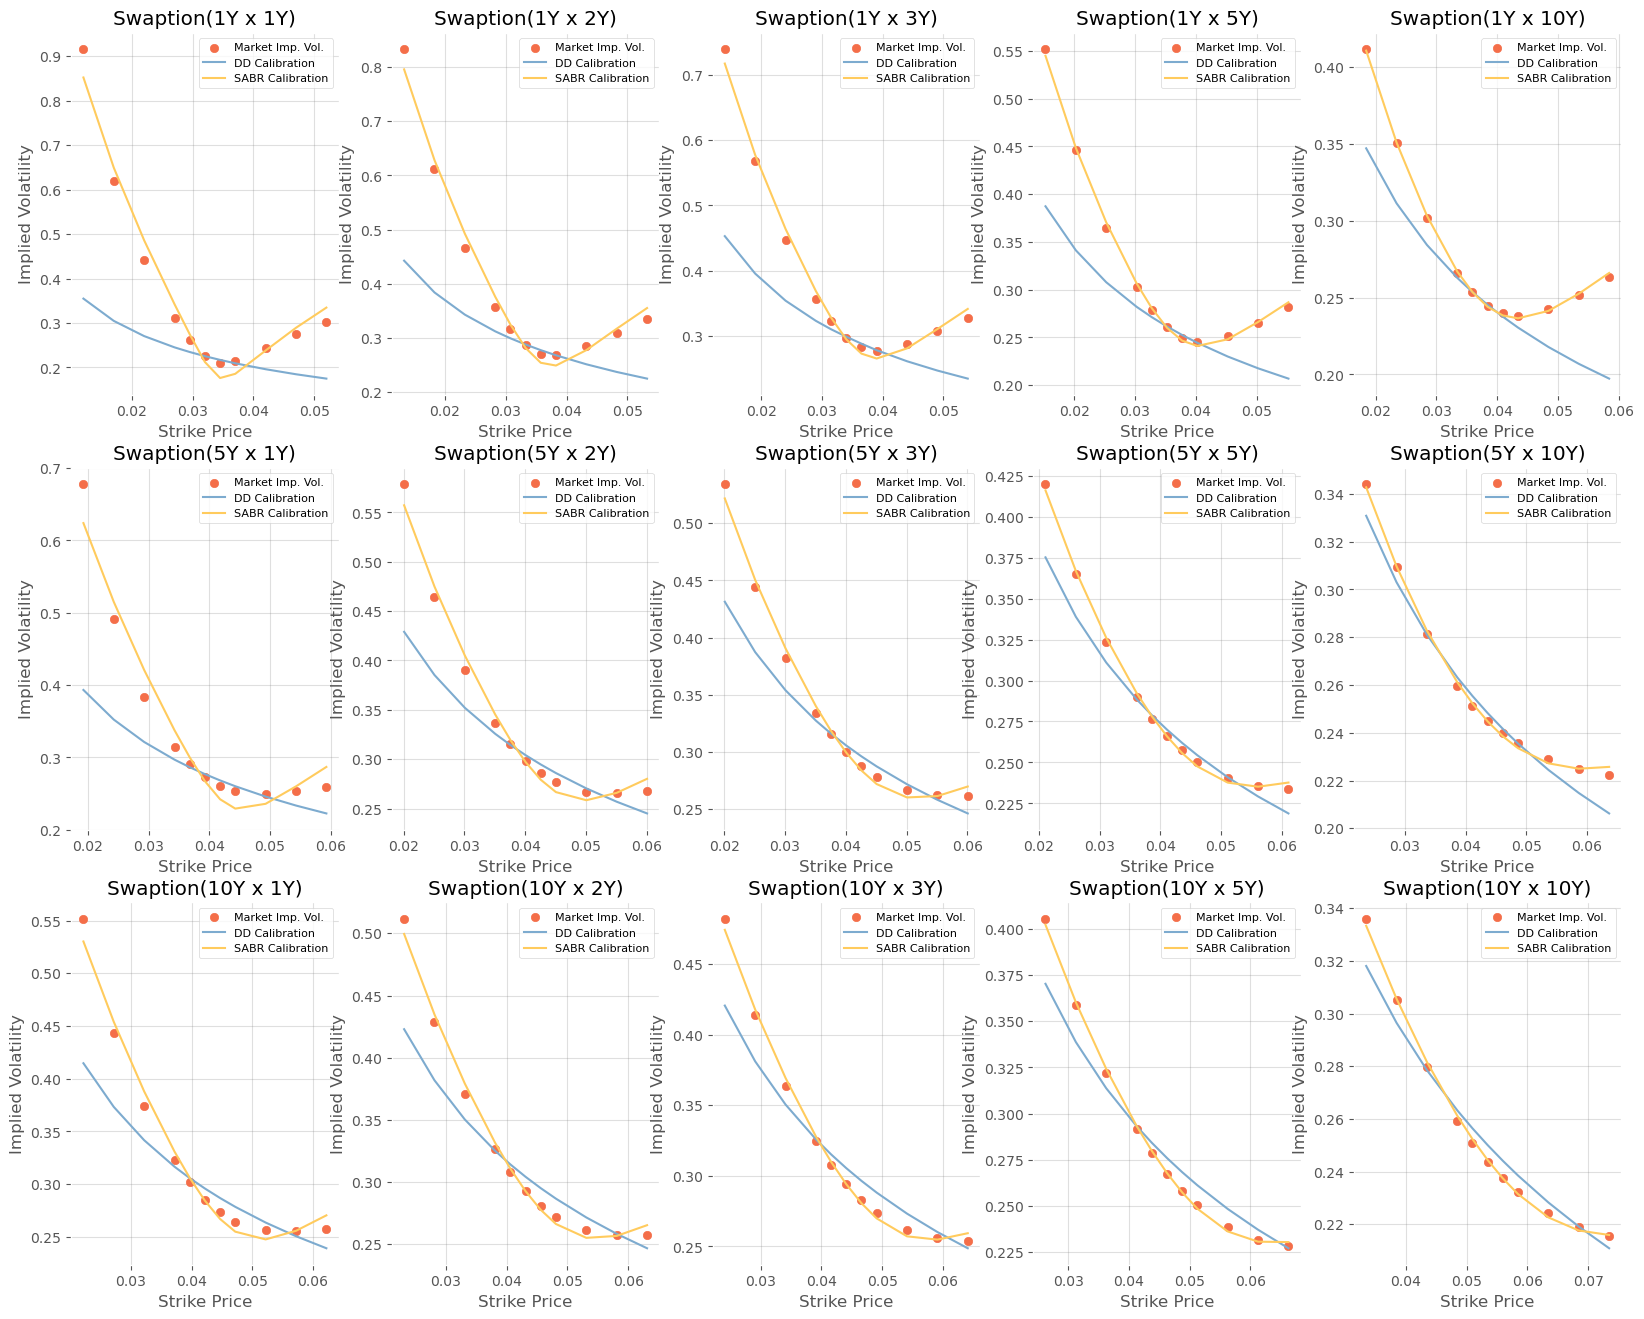

In [76]:
plt.figure(figsize=(20, 16))
for i in range(len(swap_data)):
    plt.subplot(3,5,i+1)
    draw_graph(i)

#  <a id = "p4"> 4.<font color = "green">Price Swaptions with Different Models [(back to contents)](#top)

Import the parameters value from Q1 and Q2.

In [24]:
df_sigma = pd.DataFrame({"start": swap_data1["Expiry"],
                         "tenor": swap_data1["Tenor"],
                         "Beta": beta_ls,
                         "alpha": fsr['alpha'],
                         "rho": fsr['rho'],
                         "nu": fsr['nu'],
                         "sigma": swap_data1["ATM"]/100})
df_sigma

start  tenor          Beta     alpha       rho        nu   sigma
0       1      1  1.635079e-10  0.139074 -0.633223  2.049416   0.225
1       1      2  6.209890e-08  0.184650 -0.525114  1.677383  0.2872
2       1      3  9.101406e-13  0.196851 -0.482848  1.438125  0.2978
3       1      5  3.132764e-06  0.178059 -0.414493  1.064842  0.2607
4       1     10  2.489156e-05  0.169984 -0.255690  0.792209  0.2447
5       5      1  8.973071e-07  0.166618 -0.585668  1.340427  0.2726
6       5      2  1.571027e-07  0.199534 -0.547030  1.062005  0.2983
7       5      3  1.579090e-05  0.210314 -0.549687  0.936773  0.2998
8       5      5  7.319276e-06  0.190244 -0.506814  0.674546   0.266
9       5     10  5.778981e-02  0.174809 -0.415705  0.511310  0.2451
10     10      1  5.174896e-07  0.178282 -0.548440  1.010303  0.2854
11     10      2  4.086106e-08  0.196313 -0.547530  0.928630  0.2928
12     10      3  1.620367e-06  0.208253 -0.553589  0.871684   0.294
13     10      5  6.130551e-05  0.201583 -0.563656  0.722512  0.2674
14     10     10  6.459033e-04  0.180231 -0.508403  0.580357  0.2437

Define interpolation function.

In [25]:
def interpol(x1,y1,x2,y2,x):
    return y1+(x-x1)*((y2-y1)/(x2-x1))

In [26]:
def value_obtain(start,tenor,name):
    SABR_Alpha_10_1 = df_sigma[df_sigma["start"] == start]
    SABR_Alpha_10_1 = SABR_Alpha_10_1[SABR_Alpha_10_1["tenor"] == tenor][name]
    return float(SABR_Alpha_10_1)

In [27]:
def value_compute(start1,start2,tenor,name,start3):
    y1 = value_obtain(start1,tenor,name)
    y2 = value_obtain(start2,tenor,name)
    return interpol(start1,y1,start2,y2,start3)

Calculate forward rates.

In [28]:
DF_semi_annual = pd.read_excel('IRS_data_final.xlsx')
DF_semi_annual.head()

Unnamed: 0  Tenor     Rate     ON_DF  LIBOR_DF  LIBOR_Rate
0           0    0.5  0.02500  0.998752  0.987654    0.025000
1           1    1.0  0.02800  0.997009  0.972577    0.031005
2           2    1.5  0.02900  0.995270  0.957378    0.031751
3           3    2.0  0.03000  0.993531  0.942179    0.032263
4           4    2.5  0.03075  0.991773  0.926330    0.034218

In [29]:
Expiry = ['1Y', "2Y",'5Y','8Y', '10Y']
Tenor = ['1Y', "2Y", '3Y', '5Y','10Y']

fsw = []
for ex in Expiry:
    for te in Tenor:
        i = int(ex.strip()[:-1])
        j = int(te.strip()[:-1])
        deno = 0.5*sum(DF_semi_annual.ON_DF[2*i:2*(i+j)])
        
        terms = []
        for x in range(2*i, 2*(i+j)):
            no = DF_semi_annual.ON_DF[x] * (DF_semi_annual.LIBOR_DF[x-1] - DF_semi_annual.LIBOR_DF[x])/DF_semi_annual.LIBOR_DF[x]
            terms.append(no)
        numer = sum(terms)
        
        fsw.append(numer/deno)

fsw_array = np.array(fsw).reshape(5, 5)
forward_swap = pd.DataFrame(fsw_array, columns = Tenor, index = Expiry)
forward_swap

1Y        2Y        3Y        5Y       10Y
1Y   0.032007  0.033259  0.034011  0.035255  0.038428
2Y   0.034516  0.035018  0.035018  0.037027  0.039634
5Y   0.039274  0.040075  0.040072  0.041093  0.043634
8Y   0.041740  0.042646  0.042495  0.043512  0.048711
10Y  0.042189  0.043116  0.044097  0.046249  0.053458

Define function to calculate swaption price.

In [30]:
def Black76_Call(F, K, sigma, PVBP, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return PVBP*(F*norm.cdf(d1) - K*norm.cdf(d2))

def Black76_Put(F, K, sigma, PVBP, T):
    d1 = (np.log(F/K) + 1/2 * sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return PVBP*(K*norm.cdf(-d2) - F*norm.cdf(-d1))

def DD_Call(F, K, sigma, PVBP, beta, T):   
    return Black76_Call(F/beta, K + ((1-beta)/beta)*F, sigma*beta, PVBP, T)

def DD_Put(F, K, sigma, PVBP, beta, T):
    return Black76_Put(F/beta, K + ((1-beta)/beta)*F, sigma*beta, PVBP, T)

## Payer $2y \times 10y$, with $K = 1\%, 2\%, 3\%, 4\%, 5\%, 6\%, 7\%, 8\%$

In [31]:
dd_sigma_2_10 = value_compute(1,5,10,"sigma",2)
dd_Beta_2_10 = value_compute(1,5,10,"Beta",2)
SABR_Alpha_2_10 = value_compute(1,5,10,"alpha",2)
SABR_nu_2_10 = value_compute(1,5,10,"nu",2)
SABR_Rho_2_10 = value_compute(1,5,10,"rho",2)

print('\033[1mDisplaced Diffusion Model\033[0m')
print('Sigma, σ:', round(dd_sigma_2_10, 4))
print('Beta, β:', round(dd_Beta_2_10, 4))
\
print('\033[1mSABR Model\033[0m')
print('Alpha, α:', round(SABR_Alpha_2_10, 4))
print('Nu, ν:', round(SABR_nu_2_10, 4))
print('Rho, ρ:', round(SABR_Rho_2_10, 4))

Displaced Diffusion Model
Sigma, σ: 0.2448
Beta, β: 0.0145
SABR Model
Alpha, α: 0.1712
Nu, ν: 0.722
Rho, ρ: -0.2957


In [32]:
fwd1 = forward_swap.iloc[1,-1]
strikes=np.arange(0.01,0.081,0.01)
T = 2
pvbp1 = calc_pvbp(2, 12)

In [33]:
payer_DD = [DD_Call(fwd1, i, dd_sigma_2_10, pvbp1, dd_Beta_2_10, T) for i in strikes]   
payer_SABR=[Black76_Call(fwd1,i,SABR(fwd1,i,T,SABR_Alpha_2_10,0.9,SABR_Rho_2_10,SABR_nu_2_10),pvbp1, T) for i in strikes]

In [34]:
payer_2x10 = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':payer_DD,
                     'SABR': payer_SABR}).T
payer_2x10.columns=payer_2x10.iloc[0]
payer_2x10 = payer_2x10.drop(['Strikes'], axis = 0)
payer_2x10

Strikes                  0.01      0.02      0.03      0.04      0.05  \
Displaced Diffusion  0.288141  0.194933  0.112323  0.051345  0.017369   
SABR                 0.289694  0.198406  0.115133  0.051961  0.021482   

Strikes                  0.06      0.07      0.08  
Displaced Diffusion  0.004109  0.000652  0.000068  
SABR                 0.011048  0.006966  0.004974

## Receiver $8y \times 10y$, with $K = 1\%, 2\%, 3\%, 4\%, 5\%, 6\%, 7\%, 8\%$

In [35]:
dd_sigma_8_10 = value_compute(5,10,10,"sigma",8)
dd_Beta_8_10 = value_compute(5,10,10,"Beta",8)
SABR_Alpha_8_10 = value_compute(5,10,10,"alpha",8)
SABR_nu_8_10 = value_compute(5,10,10,"nu",8)
SABR_Rho_8_10 = value_compute(5,10,10,"rho",8)


print('\033[1mDisplaced Diffusion Model\033[0m')
print('Sigma, σ:', round(dd_sigma_8_10, 4))
print('Beta, β:', round(dd_Beta_8_10, 4))
\
print('\033[1mSABR Model\033[0m')
print('Alpha, α:', round(SABR_Alpha_8_10, 4))
print('Nu, ν:', round(SABR_nu_8_10, 4))
print('Rho, ρ:', round(SABR_Rho_8_10, 4))

Displaced Diffusion Model
Sigma, σ: 0.2443
Beta, β: 0.0235
SABR Model
Alpha, α: 0.1781
Nu, ν: 0.5527
Rho, ρ: -0.4713


In [36]:
fwd2 = forward_swap.iloc[3,-1]
pvbp2 = calc_pvbp(8, 18)
T2 = 8

In [37]:
rec_DD = [DD_Put(fwd2, i, dd_sigma_8_10, pvbp2, dd_Beta_8_10, T2) for i in strikes]   
rec_SABR=[Black76_Put(fwd2,i,SABR(fwd2,i,T2,SABR_Alpha_8_10,0.9,SABR_Rho_8_10,SABR_nu_8_10),pvbp2, T2) for i in strikes]

In [38]:
receiver_8x10 = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':rec_DD,
                     'SABR': rec_SABR}).T
receiver_8x10.columns=receiver_8x10.iloc[0]
receiver_8x10 = receiver_8x10.drop(['Strikes'], axis = 0)
receiver_8x10

Strikes                  0.01      0.02      0.03      0.04      0.05  \
Displaced Diffusion  0.018978  0.033897  0.056643  0.088977  0.132051   
SABR                 0.019702  0.038962  0.061556  0.090482  0.130448   

Strikes                 0.06      0.07      0.08  
Displaced Diffusion  0.18614  0.250588  0.323978  
SABR                 0.18647  0.258112  0.339643